#### Part 2:
#### In this section of the code, my focus will be on preprocessing and normalizing the data to prepare it for numerical analysis later. Right now, we have scrapped the open source data, but its unsorted and highly variable. 

Import all the relevant libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import re
import requests
import pickle
import seaborn as sns
import os
import glob
sns.set()

from functools import reduce
from datetime import timedelta, date 
start = time.time()

Declare some global variables

In [2]:
dir_name = 'C:/Users/quant/Anaconda3/@Projects'
filename_suffix = 'csv'

Read in the scrapped file

In [3]:
df_tmr=pd.read_csv('1_Weather_Raw.csv')
df_tmr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299867 entries, 0 to 299866
Data columns (total 21 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   Unnamed: 0                 299867 non-null  int64  
 1   temp_mean_daily_max        459 non-null     float64
 2   _id                        299867 non-null  int64  
 3   month                      4799 non-null    object 
 4   max_temperature            459 non-null     float64
 5   maximum_rainfall_in_a_day  459 non-null     float64
 6   mean_temp                  459 non-null     float64
 7   mean_rh                    459 non-null     float64
 8   rh_mean_daily              38 non-null      float64
 9   rh_mean_daily_minimum      38 non-null      float64
 10  rh_means_daily_maximum     38 non-null      float64
 11  year                       38 non-null      float64
 12  mean_sunshine_hrs          459 non-null     float64
 13  temp_mean_daily_min        20

C:\Users\quant\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


If you look at the count of the items in each dataframe displayed earlier (or even in the check point file), 3 things stand out. wbt_date (in file 'wet_bulb_hr') is huge, with 295K entries, temp_mean_daily_min (in file 'min_air_temp_day') only has 209 entries and rh_mean_daily (in file 'mean_hum_yr') is quite small, with only 28 entries. 

3 actions will be taken 
1. Drop rh_mean_daily - its only 28 points and wont add much to the analysis
2. Reduce 'wet_bulb_hr' - Through some averaging, I will drop the number of enteries and make the entire data set monthly values. 
3. Additionally, if you look at the way the data is distributed, it is concatenated and needs to be sorted by dates

In [4]:
df_mod=pd.read_csv('wet_bulb_hr.csv')
df_mod.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 295030 entries, 0 to 295029
Data columns (total 4 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   wbt_date              295030 non-null  object 
 1   wet_bulb_temperature  295030 non-null  float64
 2   _id                   295030 non-null  int64  
 3   wbt_time              295030 non-null  int64  
dtypes: float64(1), int64(2), object(1)
memory usage: 9.0+ MB


In [5]:
# Analyze the 4th dataframe, cell access is df['id']['col_name'][0] for first element
print(df_mod.columns.values)
print (df_mod['wbt_date'][20])
print(type(df_mod['wbt_date'][20]))
print (df_mod['wbt_time'][20])
print(type(df_mod['wbt_time'][20]))

['wbt_date' 'wet_bulb_temperature' '_id' 'wbt_time']
2020-03-31
<class 'str'>
4
<class 'numpy.int64'>


Check the format of the data. Dates are in string format, with time of data represented as single digit. This needs to be converted to time format.

In [6]:
# Convert single digit time to full format, and recast types
# To append zeros at the end
# df_mod['wbt_time'] = df_mod['wbt_time'].astype(str).str.ljust(6,'0')

#Mod Date
df_mod['wbt_date'] = pd.to_datetime(df_mod['wbt_date']) 

#Mod Time
df_mod['wbt_time'] = df_mod['wbt_time'].astype('int')
df_mod['wbt_date'] = df_mod['wbt_date'] + \
                     pd.to_timedelta(df_mod['wbt_time']-1, unit='h')

df_mod['wet_bulb_temperature'] = \
df_mod['wet_bulb_temperature'].astype('float')

#Confirm the changes are made
df_mod.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 295030 entries, 0 to 295029
Data columns (total 4 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   wbt_date              295030 non-null  datetime64[ns]
 1   wet_bulb_temperature  295030 non-null  float64       
 2   _id                   295030 non-null  int64         
 3   wbt_time              295030 non-null  int32         
dtypes: datetime64[ns](1), float64(1), int32(1), int64(1)
memory usage: 7.9 MB


Average the values in the dataframe so that it spits it out as a monthly average per year. Going to use a Multiindex approach to do this

In [7]:
df = df_mod
df = df.drop(['wbt_time','_id'], axis = 1)
df = df.groupby([df.wbt_date.dt.year,df.wbt_date.dt.month]).mean()

The multiindex now has to be flattened so that it reads in a YYYY-MM format, similar to the other data sets. The column is renamed to 'month' for consistency with the other data elements

In [8]:
# Flatten MultiIndex to Index in YYYY-MM by list comprehension
df.index = [f'{y}-{m}' for y, m in df.index]
df = df.rename_axis('month').reset_index()
print(df.info())
print(type(df['month'][0]))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404 entries, 0 to 403
Data columns (total 2 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   month                 404 non-null    object 
 1   wet_bulb_temperature  404 non-null    float64
dtypes: float64(1), object(1)
memory usage: 6.4+ KB
None
<class 'str'>


In [9]:
df['month'] = pd.to_datetime(df['month'])
print(df.head(10))
df.info()

       month  wet_bulb_temperature
0 1986-08-01             25.185139
1 1986-09-01             24.644861
2 1986-10-01             24.905376
3 1986-11-01             24.504583
4 1986-12-01             24.403495
5 1987-01-01             23.702554
6 1987-02-01             23.781994
7 1987-03-01             25.194758
8 1987-04-01             25.573194
9 1987-05-01             25.557661
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404 entries, 0 to 403
Data columns (total 2 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   month                 404 non-null    datetime64[ns]
 1   wet_bulb_temperature  404 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 6.4 KB


I will drop the irrelevant data

In [10]:
df_tmr.drop(['rh_mean_daily',
             'rh_mean_daily_minimum',
             'rh_means_daily_maximum',
             'year',
             'Unnamed: 0',
             '_id',
             'wbt_date', 
             'wet_bulb_temperature', 
             'wbt_time'],
            axis = 1, inplace=True
           )
df_tmr['month'] = pd.to_datetime(df_tmr['month']) 
df_tmr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299867 entries, 0 to 299866
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   temp_mean_daily_max        459 non-null    float64       
 1   month                      4799 non-null   datetime64[ns]
 2   max_temperature            459 non-null    float64       
 3   maximum_rainfall_in_a_day  459 non-null    float64       
 4   mean_temp                  459 non-null    float64       
 5   mean_rh                    459 non-null    float64       
 6   mean_sunshine_hrs          459 non-null    float64       
 7   temp_mean_daily_min        209 non-null    float64       
 8   temp_extremes_min          459 non-null    float64       
 9   rh_extremes_minimum        459 non-null    float64       
 10  no_of_rainy_days           459 non-null    float64       
 11  total_rainfall             459 non-null    float64       
dtypes:

Now combine all the data into 1 file. The data here is the averaged 'wet_bulb_hr' with all the other datasets previoulsy scrapped.

In [11]:
combine_df = pd.concat([df_tmr,df], ignore_index=True).reset_index(drop=True)
df_sf = combine_df.sort_values(by='month',axis = 0, ascending=True)
df_sf = df_sf.reset_index()
df_final = df_sf.drop(['index'], axis=1)
df_final.dropna()
df_final = df_final.groupby('month').sum()
print(df_final.shape)
df_final.head(10)

(459, 12)


,temp_mean_daily_max,max_temperature,maximum_rainfall_in_a_day,mean_temp,mean_rh,mean_sunshine_hrs,temp_mean_daily_min,temp_extremes_min,rh_extremes_minimum,no_of_rainy_days,total_rainfall,wet_bulb_temperature
month,,,,,,,,,,,,
1982-01-01,29.8,31.9,36.5,25.9,81.2,5.6,0.0,21.9,49.0,10.0,107.1,0.0
1982-02-01,32.3,34.3,9.4,27.1,79.5,7.6,0.0,22.6,49.0,5.0,27.8,0.0
1982-03-01,31.7,34.3,61.7,27.2,82.3,5.1,0.0,22.3,51.0,11.0,160.8,0.0
1982-04-01,31.4,33.2,45.1,27.0,85.9,4.7,0.0,22.2,54.0,14.0,157.0,0.0
1982-05-01,31.7,32.9,33.0,28.0,83.2,5.8,0.0,23.7,57.0,10.0,102.2,0.0
1982-06-01,31.9,33.3,20.6,28.4,80.3,7.3,0.0,23.1,53.0,8.0,59.5,0.0
1982-07-01,31.6,33.0,17.2,28.2,77.6,7.6,0.0,22.1,38.0,8.0,76.3,0.0
1982-08-01,31.1,33.2,57.7,27.7,80.4,5.4,0.0,21.9,52.0,11.0,169.5,0.0
1982-09-01,31.4,33.2,18.0,27.9,80.6,5.2,0.0,23.5,49.0,9.0,54.1,0.0


Convert the index to a column that can be referenced for time-series analysis

In [12]:
df_final.index.rename("Year-month", inplace=True)
df_final.reset_index(inplace=True)
df_final

,Year-month,temp_mean_daily_max,max_temperature,maximum_rainfall_in_a_day,mean_temp,mean_rh,mean_sunshine_hrs,temp_mean_daily_min,temp_extremes_min,rh_extremes_minimum,no_of_rainy_days,total_rainfall,wet_bulb_temperature
0,1982-01-01,29.8,31.9,36.5,25.9,81.2,5.6,0.0,21.9,49.0,10.0,107.1,0.000000
1,1982-02-01,32.3,34.3,9.4,27.1,79.5,7.6,0.0,22.6,49.0,5.0,27.8,0.000000
2,1982-03-01,31.7,34.3,61.7,27.2,82.3,5.1,0.0,22.3,51.0,11.0,160.8,0.000000
3,1982-04-01,31.4,33.2,45.1,27.0,85.9,4.7,0.0,22.2,54.0,14.0,157.0,0.000000
4,1982-05-01,31.7,32.9,33.0,28.0,83.2,5.8,0.0,23.7,57.0,10.0,102.2,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
454,2019-11-01,32.3,34.4,73.4,28.0,79.2,5.5,25.4,22.9,45.0,15.0,137.4,25.128194
455,2019-12-01,30.1,32.3,74.2,26.7,83.9,4.8,24.6,22.7,47.0,14.0,421.5,24.581317
456,2020-01-01,31.7,32.8,38.0,27.7,77.9,7.1,25.2,23.8,43.0,6.0,88.4,24.690726
457,2020-02-01,31.7,33.1,23.8,27.9,76.0,8.3,25.3,23.7,45.0,8.0,65.0,24.543391


Just a quick check to see the data - after all, a pictyure is worth a thousand words

In [13]:
print(df_final.columns.values)
df_final.describe(include = 'all')

['Year-month' 'temp_mean_daily_max' 'max_temperature'
 'maximum_rainfall_in_a_day' 'mean_temp' 'mean_rh' 'mean_sunshine_hrs'
 'temp_mean_daily_min' 'temp_extremes_min' 'rh_extremes_minimum'
 'no_of_rainy_days' 'total_rainfall' 'wet_bulb_temperature']


,Year-month,temp_mean_daily_max,max_temperature,maximum_rainfall_in_a_day,mean_temp,mean_rh,mean_sunshine_hrs,temp_mean_daily_min,temp_extremes_min,rh_extremes_minimum,no_of_rainy_days,total_rainfall,wet_bulb_temperature
count,459,459.000000,459.000000,459.000000,459.000000,459.000000,459.000000,459.000000,459.000000,459.000000,459.000000,459.000000,459.000000
unique,459,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,2009-09-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
first,1982-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,2020-03-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,31.520479,33.377778,52.381046,27.658824,82.485403,5.677560,11.454466,22.631155,50.708061,13.943355,175.912636,22.283435
std,NaN,0.873491,0.818019,35.797789,0.806431,3.343576,1.210542,12.550231,0.749825,5.559696,4.950966,113.573097,8.248878
min,NaN,28.800000,31.300000,0.200000,25.400000,72.000000,2.700000,0.000000,20.200000,33.000000,1.000000,0.200000,0.000000
25%,NaN,31.000000,32.800000,30.500000,27.100000,80.650000,4.800000,0.000000,22.100000,47.000000,11.000000,88.850000,24.721438


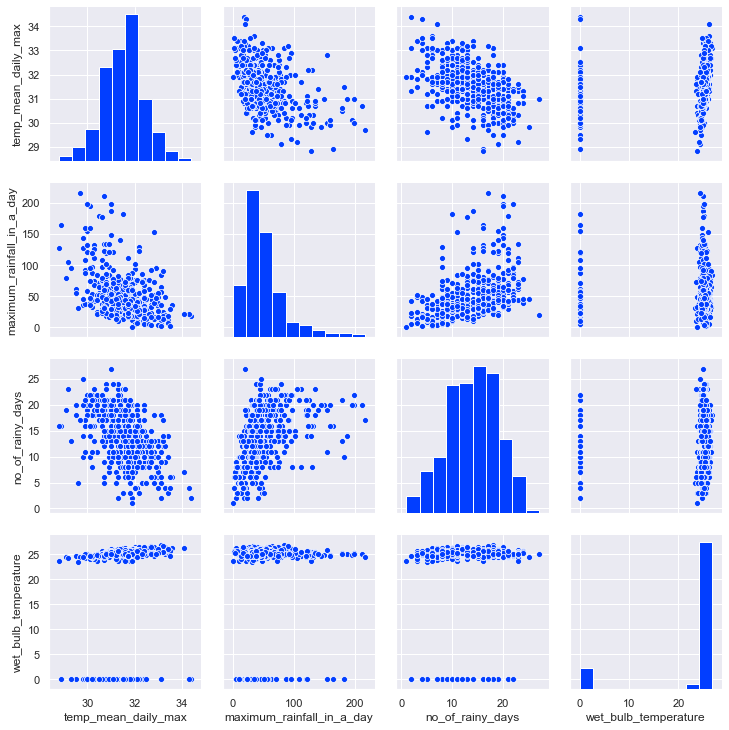

In [14]:
sns.set_palette("bright")
sns.pairplot(df_final[['temp_mean_daily_max', 'maximum_rainfall_in_a_day', 'no_of_rainy_days', 'wet_bulb_temperature']])

Rearrange the columns before creating a checkpoint file - this file will also be used for the final step of performing the analysis

In [15]:
cols = ['Year-month', 'temp_mean_daily_min', 'temp_extremes_min', 
        'temp_mean_daily_max', 'mean_temp', 'max_temperature', 
        'mean_sunshine_hrs', 'wet_bulb_temperature',
        'maximum_rainfall_in_a_day', 'total_rainfall', 
        'rh_extremes_minimum', 'mean_rh', 'no_of_rainy_days',
       ]

data_preproc = df_final[cols]
base_filename = '2_Weather_Proc'
csvs_sht = os.path.join(dir_name, base_filename + "." + filename_suffix)
data_preproc.to_csv(csvs_sht, index = False, header=True)
print ("Final File Extract Produced")

Final File Extract Produced


In [16]:
count = 'Completed Process'
elapsed = (time.time() - start)
print ("%s in %s seconds" % (count,elapsed))

Completed Process in 6.52860164642334 seconds
